# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [78]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [79]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [80]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-15 09:00:00+09:00,47002.300781,47164.078125,46910.828125,47147.050781,0,0.0,0.0
2025-10-15 09:15:00+09:00,47147.738281,47242.898438,47095.441406,47237.710938,0,0.0,0.0
2025-10-15 09:30:00+09:00,47216.449219,47243.808594,47068.128906,47163.589844,0,0.0,0.0
2025-10-15 09:45:00+09:00,47149.269531,47269.300781,47149.269531,47250.871094,0,0.0,0.0
2025-10-15 10:00:00+09:00,47243.191406,47246.730469,47127.398438,47202.371094,0,0.0,0.0
2025-10-15 10:15:00+09:00,47200.570312,47306.339844,47185.421875,47298.078125,0,0.0,0.0
2025-10-15 10:30:00+09:00,47295.218750,47328.960938,47264.230469,47320.800781,0,0.0,0.0
2025-10-15 10:45:00+09:00,47319.949219,47319.949219,47262.808594,47290.371094,0,0.0,0.0
2025-10-15 11:00:00+09:00,47293.910156,47366.019531,47283.398438,47358.128906,0,0.0,0.0


## 前日終値の取得

In [81]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-08 00:00:00+09:00    47734.988281
2025-10-09 00:00:00+09:00    48580.441406
2025-10-10 00:00:00+09:00    48088.800781
2025-10-14 00:00:00+09:00    46847.320312
2025-10-15 00:00:00+09:00    47463.308594
Name: Close, dtype: float64


Date
2025-10-14 00:00:00+09:00    46847.320312
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [82]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+154.98


## ローソク足チャート（小さいサイズ）

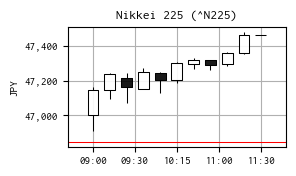

In [83]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [84]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [85]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-14 08:00:00+09:00,152.334000,152.380005,152.320999,152.348007,0,0.0,0.0
2025-10-14 08:15:00+09:00,152.345001,152.352005,152.304993,152.341003,0,0.0,0.0
2025-10-14 08:30:00+09:00,152.339996,152.354004,152.274994,152.339996,0,0.0,0.0
2025-10-14 08:45:00+09:00,152.334000,152.460007,152.287003,152.451004,0,0.0,0.0
2025-10-14 09:00:00+09:00,152.451004,152.537003,152.423004,152.449997,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-15 11:00:00+09:00,151.296005,151.315002,151.128998,151.153000,0,0.0,0.0
2025-10-15 11:15:00+09:00,151.151993,151.235992,151.095993,151.160995,0,0.0,0.0
2025-10-15 11:30:00+09:00,151.158005,151.177002,151.042999,151.080002,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [86]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-15 09:00:00+09:00,309.616761,310.682431,309.014206,310.570268
2025-10-15 09:15:00+09:00,310.769275,311.396513,310.424566,311.362321
2025-10-15 09:30:00+09:00,311.542503,311.723025,310.563859,311.193727
2025-10-15 09:45:00+09:00,311.080792,311.872732,311.080792,311.751137
2025-10-15 10:00:00+09:00,311.974218,311.997589,311.209570,311.704658
2025-10-15 10:15:00+09:00,311.781297,312.479953,311.681234,312.425380
2025-10-15 10:30:00+09:00,312.359048,312.581896,312.154387,312.528003
2025-10-15 10:45:00+09:00,312.755772,312.755772,312.378107,312.560279
2025-10-15 11:00:00+09:00,312.887671,313.364734,312.818128,313.312531


### 前日の終値のドル円レートから、前日の終値のドル換算

In [87]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-14 15:15:00+09:00


np.float64(151.75799560546875)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

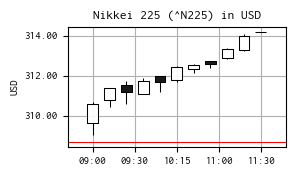

In [88]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()